In [ ]:
###
# File name: Visualize.ipynb (jupyter notebook)
# Description: make figures to be inserted into paper
# Created on: 2024-05-20
# Modification History
#   - 2024-05-20: (edited by Gyumin Lee) C-T and C-T-C-T networks
# Version: 0.1
###

# Load data

In [1]:
def save_hdf5(data_to_save, data_path):
    import h5py
    from scipy.sparse import csr_matrix, lil_matrix
    with h5py.File(data_path, "w") as f:
        if isinstance(data_to_save, (csr_matrix, lil_matrix)):
            f.create_dataset("data", data=data_to_save.data)
            f.create_dataset("indices", data=data_to_save.indices)
            f.create_dataset("indptr", data=data_to_save.indptr)
            f.attrs["shape"] = data_to_save.shape
            f.attrs["type"] = "sparse"
        else:
            f.create_dataset("data", data=data_to_save)
            f.attrs["type"] = "dense"
    
def load_hdf5(data_path):
    import h5py
    from scipy.sparse import csr_matrix
    with h5py.File(data_path, "r") as f:
        if f.attrs["type"]=="sparse":
            data = f["data"][:]
            indices = f["indices"][:]
            indptr = f["indptr"][:]
            shape = f.attrs["shape"]
            return csr_matrix((data, indices, indptr), shape=shape)
        else:
            return f["data"][:]

In [465]:
import requests
import json
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',200,'display.max_columns',50)
import csv
import time
import pickle
import os
import sys
import copy
import matplotlib.pyplot as plt
import networkx as nx
import plotly
    
from plotly import graph_objects
from tqdm import tqdm
from scipy import sparse as sps

In [3]:
root = "/home2/glee/Drug_Discovery_Research"
data_path = os.path.join(root, "data")

In [4]:
CT_adj = load_hdf5(os.path.join(data_path, "adjacency_matrices", "sps_CT_adj.h5")).toarray()
CTC_adj = load_hdf5(os.path.join(data_path, "adjacency_matrices", "sps_CTC_adj.h5")).toarray()
CTCT_adj = load_hdf5(os.path.join(data_path, "adjacency_matrices", "sps_CTCT_adj.h5")).toarray()

In [5]:
## Make T-C, T-C-T-C adjacency matrix; Leave 2-hop elements only
only_CTCT = (CTCT_adj.astype(np.int8) - CT_adj.astype(np.int8)).astype(bool)
TC_adj = CT_adj.T
TCTC_adj = CTCT_adj.T
only_TCTC = only_CTCT.T

# Visualize

## C-T & C-T-C-T networks

### Practice

In [ ]:
## Set sample adjacency matrix
n_samples_C, n_samples_T = 500, 100
sample_adj = CT_adj[:n_samples_C,:n_samples_T]
rows, cols = np.where(sample_adj==True)

## Make edges and labels
edges = list(zip(i_to_C_cid[rows].tolist(), i_to_T_id[cols].tolist()))
node_cids = np.unique(i_to_C_cid[rows])
node_tids = np.unique(i_to_T_id[cols])
labels = {}
labels.update({cid: "C_"+cid for cid in node_cids})
labels.update({tid: "T_"+tid for tid in node_tids})

## Make NetworkX graph with positions
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, k=0.24, iterations=60, seed=101)

for p in list(pos.keys()):
    G.nodes[p]["pos"] = pos[p]
    
# node_size = min(50000 / (n_samples_C+n_samples_T), 700)
node_size = max(750 - (n_samples_C+n_samples_T), 200)

In [ ]:
## Draw using NetworkX
fig, ax = plt.subplots(figsize=(15,10))

options = {"edgecolors": "black", "node_size": node_size, "alpha": 0.8, "ax": ax}
nx.draw_networkx_nodes(G, pos, nodelist=node_cids, label="Compound", node_color="tab:red", **options)
nx.draw_networkx_nodes(G, pos, nodelist=node_tids, label="Target", node_color="tab:blue", **options)
# ids = nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color="black", verticalalignment="center")

nx.draw_networkx_edges(
    G,
    pos,
    edgelist=G.edges,
    width=3,
    alpha=0.5,
    edge_color="tab:gray",
)

# for node, t in ids.items():
#     t.set_position((t.get_position()[0], t.get_position()[1]-0.08))
#     t.set_clip_on(False)

plt.tight_layout()
plt.legend(loc="lower right", labelspacing=2, borderpad=1.05)
plt.axis("off")
plt.show()

In [ ]:
## Draw using Plotly
edge_x, edge_y = [], []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = graph_objects.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=5, color='rgba(211,211,211,0.7)'), # Gray
    hoverinfo='none',
    mode='lines',
    showlegend=False)

nodes_cid_1 = [G.nodes[node]["pos"][0] for node in node_cids]
nodes_cid_2 = [G.nodes[node]["pos"][1] for node in node_cids]
labels_cid = ["C_"+cid for cid in node_cids]

node_trace_cid = graph_objects.Scatter(
    x=nodes_cid_1, y=nodes_cid_2,
    mode='markers+text',
    hoverinfo='text',
    name='Compounds',
    text=labels_cid,
    textposition="bottom center",
    marker=dict(
        size=25,
        line_width=2))

nodes_tid_1 = [G.nodes[node]["pos"][0] for node in node_tids]
nodes_tid_2 = [G.nodes[node]["pos"][1] for node in node_tids]
labels_tid = ["T_"+tid for tid in node_tids]

node_trace_tid = graph_objects.Scatter(
    x=nodes_tid_1, y=nodes_tid_2,
    mode='markers+text',
    hoverinfo='text',
    name='Targets',
    text=labels_tid,
    textposition="bottom center",
    marker=dict(
        size=25,
        line_width=2))

fig = graph_objects.Figure(data=[edge_trace, node_trace_cid, node_trace_tid],
             layout=graph_objects.Layout(
#                 title='<br>Network graph made with Python',
#                 titlefont_size=16,
                showlegend=True,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                plot_bgcolor='ghostwhite',
                width=1000,
                height=600,
#                 annotations=[ dict(
#                     showarrow=False,
#                     xref="paper", yref="paper",
#                     x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()

### Drawing

In [538]:
def draw_network(adjmat, cids, tids, sample_index=None, tool="networkx", n_samples={}, options={}, n_hops=1):
    curr_font = 'FreeSans'
    if n_hops > 2:
        print("Not implemented, proceed with n_hops=2")    
    if isinstance(sample_index, tuple):
        sample_row_index, sample_col_index = sample_index[0], sample_index[1]
    elif sample_index == "Random":
        sample_row_index = np.random.choice(adjmat.shape[0], n_samples["C"], replace=False)
        sample_rows = adjmat[sample_row_index]
        nonzero_cols = np.nonzero(sample_rows)
        n_choice_cols = min(n_samples["T"], len(np.unique(np.nonzero(sample_rows)[1])))
        sample_col_index = np.random.choice(nonzero_cols[1], n_choice_cols)
    else:
        sample_row_index = np.arange(n_samples["C"])
        sample_col_index = np.arange(n_sampled["T"])
    
    ## Extract sample set
    sample_CT_adj = adjmat[sample_row_index][:, sample_col_index]
    selected_elements = np.nonzero(sample_CT_adj)
    
    ## Make edges and labels
    dict_indexes = {}
    dict_indexes[1] = {}
    dict_indexes[1]["rows"] = sample_row_index[selected_elements[0]]
    dict_indexes[1]["cols"] = sample_col_index[selected_elements[1]]

    dict_edges = {}
    dict_edges[1] = list(zip(cids[dict_indexes[1]["rows"]].tolist(), tids[dict_indexes[1]["cols"]].tolist()))
    
    if n_hops > 1:
        sample_CTCT_adj = sample_CT_adj.dot(sample_CT_adj.T).dot(sample_CT_adj)
        dict_indexes[2] = {}
        dict_indexes[2]["rows"] = sample_row_index[np.nonzero(sample_CTCT_adj)[0]]
        dict_indexes[2]["cols"] = sample_col_index[np.nonzero(sample_CTCT_adj)[1]]
        dict_edges[2] = list(zip(cids[dict_indexes[2]["rows"]].tolist(), tids[dict_indexes[2]["cols"]].tolist()))
        dict_edges[2] = [e for e in dict_edges[2] if (e not in dict_edges[1])]
    
    node_cids = np.unique(cids[dict_indexes[1]["rows"]])
    node_tids = np.unique(tids[dict_indexes[1]["cols"]])
    
    labels = {}
    labels.update({cid: "C_"+cid for cid in node_cids})
    labels.update({tid: "T_"+tid for tid in node_tids})

    ## Make NetworkX graph with positions
    G = nx.Graph()
    G.add_edges_from(dict_edges[1])
    if n_hops > 1:
        G.add_edges_from(dict_edges[2])
    pos = nx.spring_layout(G, k=options["k"], iterations=options["iterations"], seed=options["seed"])

    for p in list(pos.keys()):
        G.nodes[p]["pos"] = pos[p]
        
    pos_adjusted = copy.deepcopy(pos)
    for p in pos:
        pos_adjusted[p][1] -= 0.075
        
    if tool=="networkx":
        ## Draw using NetworkX
        fig, ax = plt.subplots(figsize=(12,9))
        fig.set_facecolor("#F8F8FF")

        node_size = max(1750 - (n_samples["C"]+n_samples["T"]), 200)
        nx.draw_networkx_nodes(G, pos, nodelist=node_cids, label="Compound", node_color="tomato", edgecolors='black', linewidths=1.5, node_size=node_size, alpha=1, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=node_tids, label="Protein", node_color="steelblue", edgecolors='black', linewidths=1.5, node_size=node_size, alpha=1, ax=ax)
        if options["show_label"]:
            ids = nx.draw_networkx_labels(G, pos_adjusted, labels,  font_size=20, font_color="black", font_family=curr_font, verticalalignment="top")

        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=dict_edges[1],
            width=2.2,
            alpha=0.7 if n_hops==1 else 0.9,
            edge_color="gray" if n_hops==1 else "black",
        )

        if n_hops > 1:
            for edge in dict_edges[2]:
                source, target = edge
                rad = 0.25
                ax.annotate("",
                    xy=pos[source],
                    xytext=pos[target],
                    arrowprops=dict(arrowstyle="-", color="gray", 
                        linestyle="--",
                        connectionstyle="arc3,rad={}".format(rad), 
                        alpha=0.6, linewidth=2.2))        

        plt.tight_layout()
        plt.legend(loc="lower right", labelspacing=2, borderpad=1, bbox_to_anchor=[1,0,0.3,0.5], fontsize=20, prop={'family': curr_font, "size": 22.5, "weight": "regular"})
        plt.axis("off")
        plt.show()
        
    elif tool=="plotly":
        ## Draw using Plotly
        node_size = max(25 - (n_samples["C"]+n_samples["T"])/25, 10)
        
        plotly_edges = {}
        plotly_edges[1] = {"x": [], "y": []}
        for edge in dict_edges[1]:
            x0, y0 = G.nodes[edge[0]]['pos']
            x1, y1 = G.nodes[edge[1]]['pos']
            plotly_edges[1]["x"].append(x0)
            plotly_edges[1]["x"].append(x1)
            plotly_edges[1]["x"].append(None)
            plotly_edges[1]["y"].append(y0)
            plotly_edges[1]["y"].append(y1)
            plotly_edges[1]["y"].append(None)

        edge_traces = {}
        edge_traces[1] = graph_objects.Scatter(
            x=plotly_edges[1]["x"], y=plotly_edges[1]["y"],
            line=dict(width=1.5, color='rgba(100,100,100,0.7)' if n_hops==1 else 'rgba(20,20,20,1)', shape='linear'), # Black
            hoverinfo='none',
            mode='lines',
            showlegend=False)

        if n_hops > 1:
            plotly_edges[2] = {"x": [], "y": []}
            for edge in dict_edges[2]:
                x0, y0 = G.nodes[edge[0]]['pos']
                x1, y1 = G.nodes[edge[1]]['pos']
                plotly_edges[2]["x"].append(x0)
                plotly_edges[2]["x"].append(x1)
                plotly_edges[2]["x"].append(None)
                plotly_edges[2]["y"].append(y0)
                plotly_edges[2]["y"].append(y1)
                plotly_edges[2]["y"].append(None)

            edge_traces[2] = graph_objects.Scatter(
                x=plotly_edges[2]["x"], y=plotly_edges[2]["y"],
                line=dict(width=2.1, color='rgba(100,100,100,0.7)', shape='spline', dash="dot"), # Gray
                hoverinfo='none',
                mode='lines',
                showlegend=False)
        
        nodes_cid_1 = [G.nodes[node]["pos"][0] for node in node_cids]
        nodes_cid_2 = [G.nodes[node]["pos"][1] for node in node_cids]
        labels_cid = ["C_"+cid for cid in node_cids]

        node_trace_cid = graph_objects.Scatter(
            x=nodes_cid_1, y=nodes_cid_2,
            mode='markers+text' if options["show_label"] else 'markers',
            hoverinfo='text',
            name='Compound',
            text=labels_cid,
            textposition="bottom center",
            marker=dict(
                size=node_size,
                color='tomato',
                line_width=2))

        nodes_tid_1 = [G.nodes[node]["pos"][0] for node in node_tids]
        nodes_tid_2 = [G.nodes[node]["pos"][1] for node in node_tids]
        labels_tid = ["T_"+tid for tid in node_tids]

        node_trace_tid = graph_objects.Scatter(
            x=nodes_tid_1, y=nodes_tid_2,
            mode='markers+text' if options["show_label"] else 'markers',
            hoverinfo='text',
            name='Protein',
            text=labels_tid,
            textposition="bottom center",
            marker=dict(
                size=node_size,
                color='steelblue',
                line_width=2))

        fig = graph_objects.Figure(data=(list(edge_traces.values()) + [node_trace_cid, node_trace_tid]),
                     layout=graph_objects.Layout(
                        showlegend=True,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        plot_bgcolor='ghostwhite',
                        width=1000,
                        height=600,
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                        )

        fig.show()       
    else:
        print("Not implemented")
        return

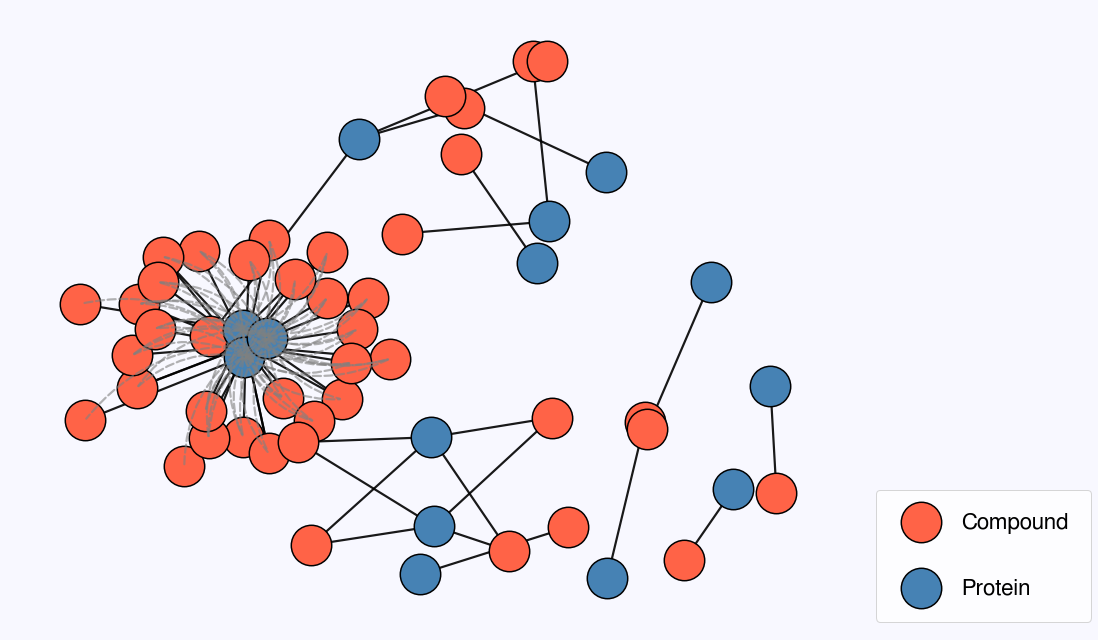

In [521]:
n_samples = {"C": 100, "T": 15}
options = {"show_label": False, "k": 0.35, "iterations": 25, "seed":100}
draw_network(CT_adj, i_to_C_cid, i_to_T_id, n_hops=2, sample_index="Random", tool="networkx", n_samples=n_samples, options=options)

In [522]:
n_samples = {"C": 100, "T": 15}
options = {"show_label": False, "k": 0.35, "iterations": 25, "seed":100}
draw_network(CT_adj, i_to_C_cid, i_to_T_id, n_hops=2, sample_index="Random", tool="plotly", n_samples=n_samples, options=options)

### Find good examples

In [452]:
good_ex_cols = [188,22,1294,6]

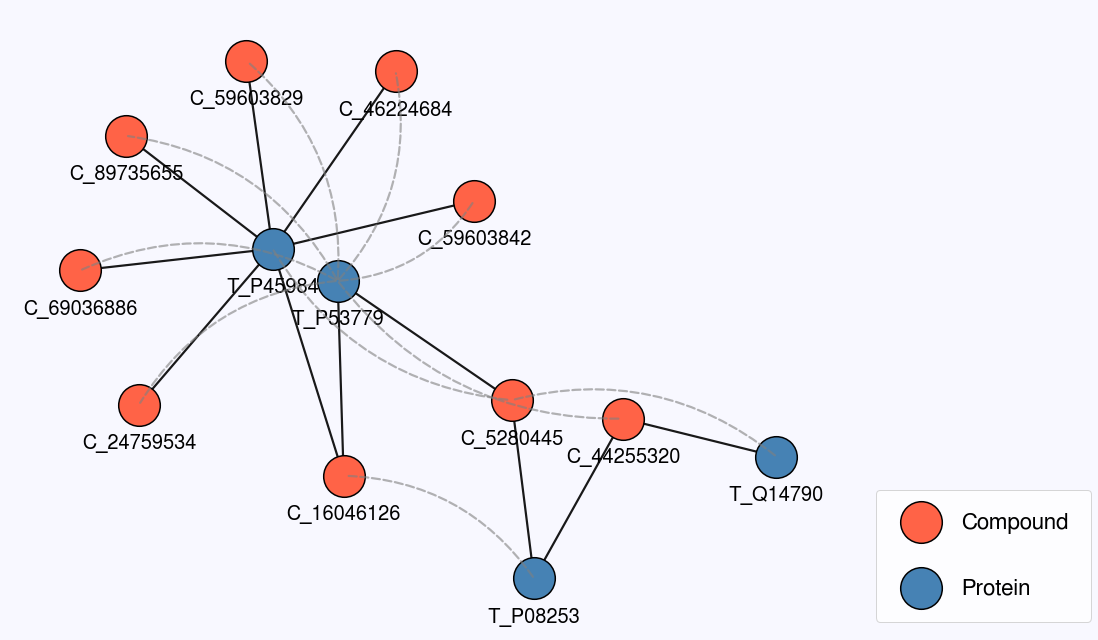

In [540]:
n_samples = {"C": 12, "T": 7}
options = {"show_label": True, "k": 0.35, "iterations": 25, "seed":100}

sample_row_index = CT_adj.sum(axis=1).argsort()[::-1][:n_samples["C"]]
sample_rows = CT_adj[sample_row_index]
nonzero_cols = np.nonzero(sample_rows)
sample_col_index = np.array(good_ex_cols)
sample_index = (sample_row_index, sample_col_index)

draw_network(CT_adj, i_to_C_cid, i_to_T_id, n_hops=2, sample_index=sample_index, tool="networkx", n_samples=n_samples, options=options)

In [541]:
n_samples = {"C": 12, "T": 7}
options = {"show_label": True, "k": 0.35, "iterations": 25, "seed":100}

sample_row_index = CT_adj.sum(axis=1).argsort()[::-1][:n_samples["C"]]
sample_rows = CT_adj[sample_row_index]
nonzero_cols = np.nonzero(sample_rows)
# n_choice_cols = min(n_samples["T"], len(np.unique(np.nonzero(sample_rows)[1])))
# sample_col_index = np.random.choice(nonzero_cols[1], n_choice_cols)
# sample_col_index = sample_rows.sum(axis=0).argsort()[::-1][:n_samples["T"]]
sample_col_index = np.array(good_ex_cols)
sample_index = (sample_row_index, sample_col_index)
# display(sample_index)

draw_network(CT_adj, i_to_C_cid, i_to_T_id, n_hops=2, sample_index=sample_index, tool="plotly", n_samples=n_samples, options=options)